# cadCAD Tutorials: The Robot and the Marbles, part 6
In parts [1](../robot-marbles-part-1/robot-marbles-part-1.ipynb) and [2](../robot-marbles-part-2/robot-marbles-part-2.ipynb) we introduced the 'language' in which a system must be described in order for it to be interpretable by cadCAD and some of the basic concepts of the library:
* State Variables
* Timestep
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters
* Policies

In [part 3](../robot-marbles-part-3/robot-marbles-part-3.ipynb) we covered how to describe the presence of asynchronous subsystems within the system being modeled in cadCAD. And [part 4](../robot-marbles-part-4/robot-marbles-part-4.ipynb) introduced Monte Carlo simulations.

In this notebook, we'll cover cadCAD's support for A/B testing, a useful feature when analyzing different design options for a system. Let's start by copying the base configuration with which we ended Part 4. Here's the description of that system:

__The robot and the marbles__  
* Picture a box (`box_A`) with ten marbles in it; an empty box (`box_B`) next to the first one; and __two__ robot arms capable of taking a marble from any one of the boxes and dropping it into the other one. 
* The robots are programmed to take one marble at a time from the box containing the largest number of marbles and drop it in the other box. They repeat that process until the boxes contain an equal number of marbles.
* The robots act __asynchronously__ and __non-deterministically__; at every timestep each robot acts with a probability P: 50% for robot 1 and 33.33% for robot 2.

In [1]:
%%capture
from random import random as rand

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
genesis_states = {
    'box_A': 10, # as per the description of the example, box_A starts out with 10 marbles in it
    'box_B': 0 # as per the description of the example, box_B starts out empty
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's leave it empty

mc = 50
sim_config_dict = {
    'T': range(10),
    'N': mc, # We'll run the same simulation 50 times; the random events in each simulation are independent
    #'M': {}
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We specify the robot arm's logic in a Policy Function
def robot_arm(params, step, sH, s):
    add_to_A = 0
    if (s['box_A'] > s['box_B']):
        add_to_A = -1
    elif (s['box_A'] < s['box_B']):
        add_to_A = 1
    return({'add_to_A': add_to_A, 'add_to_B': -add_to_A})
    
robots_probabilities = [0.5,1/3] # Robot 1 acts with a 50% probability; Robot 2, 33.33%

def robot_arm_1(params, step, sH, s):
    _robotId = 1
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return robot_arm(params, step, sH, s)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # otherwise, the robot doesn't interfere with the system

def robot_arm_2(params, step, sH, s):
    _robotId = 2
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return robot_arm(params, step, sH, s)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # otherwise, the robot doesn't interfere with the system



    
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We make the state update functions less "intelligent",
# ie. they simply add the number of marbles specified in _input 
# (which, per the policy function definition, may be negative)
def increment_A(params, step, sL, s, _input):
    y = 'box_A'
    x = s['box_A'] + _input['add_to_A']
    return (y, x)

def increment_B(params, step, sL, s, _input):
    y = 'box_B'
    x = s['box_B'] + _input['add_to_B']
    return (y, x)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robot_arm_1': robot_arm_1,
            'robot_arm_2': robot_arm_2
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': increment_A,
            'box_B': increment_B
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [2]:
%%capture
#imported some addition utilities to help with configuration set-up
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

del configs[:]

exp = Experiment()
c = config_sim(sim_config_dict)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
exp.append_configs(initial_state=genesis_states, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_configs=c #preprocessed dictionaries containing simulation parameters
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)
executor = Executor(local_mode_ctx, configs) # Pass the configuration object inside an array
raw_result, tensor, sessions = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
import pandas as pd
df = pd.DataFrame(raw_result)

In [3]:
from IPython.display import display

display(c)

tmp_rows = pd.options.display.max_rows
pd.options.display.max_rows = 10
display(df.set_index(['simulation', 'run', 'timestep', 'substep']))
pd.options.display.max_rows = tmp_rows

{'T': range(0, 10),
 'N': 1,
 'M': [{}],
 'subset_id': 0,
 'subset_window': deque([0, 0]),
 'simulation_id': 0,
 'run_id': 49}

box_A  box_B  subset
simulation run timestep substep                      
0          1   0        0           10      0       0
               1        1           10      0       0
               2        1            9      1       0
               3        1            8      2       0
               4        1            7      3       0
...                                ...    ...     ...
           50  6        1            6      4       0
               7        1            6      4       0
               8        1            5      5       0
               9        1            5      5       0
               10       1            5      5       0

[550 rows x 3 columns]

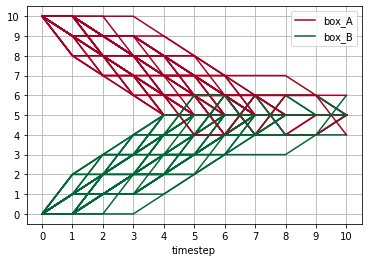

In [4]:
ax = None
for i in range(0,mc):
    ax = df[df['run']==i+1].plot('timestep', ['box_A', 'box_B'],
                                     grid=True,
                                     xticks=list(df['timestep'].drop_duplicates()), 
                                     yticks=list(range(1+max(df['box_A'].max(),df['box_B'].max()))),
                                     legend = (ax == None),
                                     colormap = 'RdYlGn',
                                     ax = ax
                                  )

## A/B testing
In order to simulate two different versions of the same system, we create two `Configuration` objects to pass to the `Executor` instead of just one. For example, suppose we wanted to test the system under two different sets of initial conditions

In [5]:
genesis_states_1 = {
    'box_A': 10, 
    'box_B': 0 
}

genesis_states_2 = {
    'box_A': 10, 
    'box_B': 4 
}

Just like we did before, we package those initial conditions along with the partial state update blocks and the simulation parameters into `Configuration` objects

In [6]:
del configs[:]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
sim_config_dict = {
    'T': range(10),
    'N': 30, # We'll run the same simulation 50 times; the random events in each simulation are independent
    #'M': {}
}
c = config_sim(sim_config_dict)
exp.append_configs(initial_state=genesis_states_1, #dict containing variable names and initial values
                        partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                        sim_configs=c #preprocessed dictionaries containing simulation parameters
                       )

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
sim_config_dict = {
    'T': range(10),
    'N': 30, # We'll run the same simulation 50 times; the random events in each simulation are independent
    #'M': {}
}
c = config_sim(sim_config_dict)
exp.append_configs(initial_state=genesis_states_2, #dict containing variable names and initial values
                        partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                        sim_configs=c #preprocessed dictionaries containing simulation parameters
                       )

And now we can execute the simulation of those two different versions of the system in parallel. In order to accomplish that, we use an `ExecutionContext` of mode `multi_proc`

In [8]:
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode) # For A/B testing we use multi_proc instead of single_proc
executor = Executor(local_mode_ctx, configs) # Pass the configuration objects inside an array

And we are ready to execute the simulation. The `execute()` method will return a list of tuples - the first element of those tuples correspond to the datapoints of each one of the versions of the system being simulated.

In [11]:
raw_result, tensor, sessions = executor.execute()
df = pd.DataFrame(raw_result)

df = pd.DataFrame(raw_result)
df.set_index(['simulation', 'run', 'timestep', 'substep'])
# print(df.head())
from IPython.display import display
tmp_rows = pd.options.display.max_rows
pd.options.display.max_rows = 10
display(df.set_index(['simulation', 'run', 'timestep', 'substep']))
pd.options.display.max_rows = tmp_rows
display(df)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 2
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 1, 30, 2)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
ExpIDs   :

box_A  box_B  subset
simulation run timestep substep                      
0          1   0        0           10      0       0
               1        1           10      0       0
               2        1           10      0       0
               3        1           10      0       0
               4        1            9      1       0
...                                ...    ...     ...
1          30  6        1            7      7       0
               7        1            7      7       0
               8        1            7      7       0
               9        1            7      7       0
               10       1            7      7       0

[660 rows x 3 columns]

,box_A,box_B,simulation,subset,run,substep,timestep
0,10,0,0,0,1,0,0
1,10,0,0,0,1,1,1
2,10,0,0,0,1,1,2
3,10,0,0,0,1,1,3
4,9,1,0,0,1,1,4
...,...,...,...,...,...,...,...
655,7,7,1,0,30,1,6
656,7,7,1,0,30,1,7
657,7,7,1,0,30,1,8
658,7,7,1,0,30,1,9


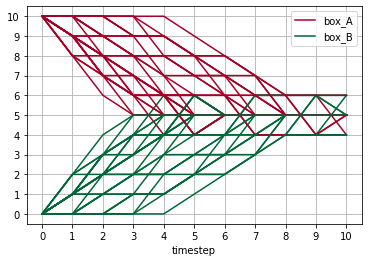

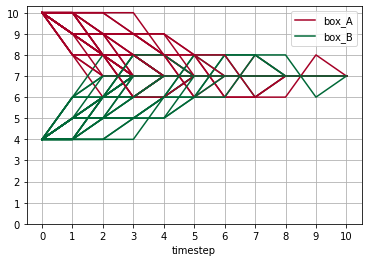

In [12]:
for simulation_id in range(2):
    ax = None
    for i in range(0,mc):
        ax = df[(df['simulation']==simulation_id) & (df['run']==i+1)].plot('timestep', ['box_A', 'box_B'],
                                         grid=True,
                                         xticks=list(df['timestep'].drop_duplicates()), 
                                         yticks=list(range(1+max(df['box_A'].max(),df['box_B'].max()))),
                                         legend = (ax == None),
                                         colormap = 'RdYlGn',
                                         ax = ax
                                      )

The same thing can be done for any sort of variation in the system being modeled: wheter it's the inclusion of a new state update function, a change in the order in which partial state update blocks get executed, or completely different policy and state update functions, all we need to do is create a different `Configuration` object for each one of the variations and pass those to the `Executor`.